In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import random


In [2]:
# Define image dimensions and batch size
img_width, img_height = 200, 200
batch_size = 32


In [3]:
# Extract class labels from folder names in the training directory
train_dir = 'training'
class_names = sorted(os.listdir(train_dir))

In [4]:
# Create data generators with data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2
)

In [5]:
# %%
#Data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


Found 4571 images belonging to 4 classes.


In [6]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 1141 images belonging to 4 classes.


In [7]:
# Build a more complex CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='softmax'))  # Number of classes
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [9]:
# Train the model
epochs = 67
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/67
142/142 [==============================] - 142s 991ms/step - loss: 1.1626 - accuracy: 0.4230 - val_loss: 1.1446 - val_accuracy: 0.4563
Epoch 2/67
142/142 [==============================] - 139s 975ms/step - loss: 0.9402 - accuracy: 0.5796 - val_loss: 0.9951 - val_accuracy: 0.6000
Epoch 3/67
142/142 [==============================] - 140s 987ms/step - loss: 0.7914 - accuracy: 0.6453 - val_loss: 1.0460 - val_accuracy: 0.5955
Epoch 4/67
142/142 [==============================] - 140s 982ms/step - loss: 0.6902 - accuracy: 0.7010 - val_loss: 1.0553 - val_accuracy: 0.6214
Epoch 5/67
142/142 [==============================] - 138s 971ms/step - loss: 0.5961 - accuracy: 0.7647 - val_loss: 0.8009 - val_accuracy: 0.6804
Epoch 6/67
142/142 [==============================] - 140s 982ms/step - loss: 0.5595 - accuracy: 0.7731 - val_loss: 0.7375 - val_accuracy: 0.7098
Epoch 7/67
142/142 [==============================] - 136s 959ms/step - loss: 0.5165 - accuracy: 0.7949 - val_loss: 0.7538 -

In [10]:
# Evaluate the model on the test set
test_generator = train_datagen.flow_from_directory(
    'testing',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1311 images belonging to 4 classes.


In [11]:
# Get true and predicted labels
y_true = test_generator.classes
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=-1)

41/41 [==============================] - 16s 381ms/step


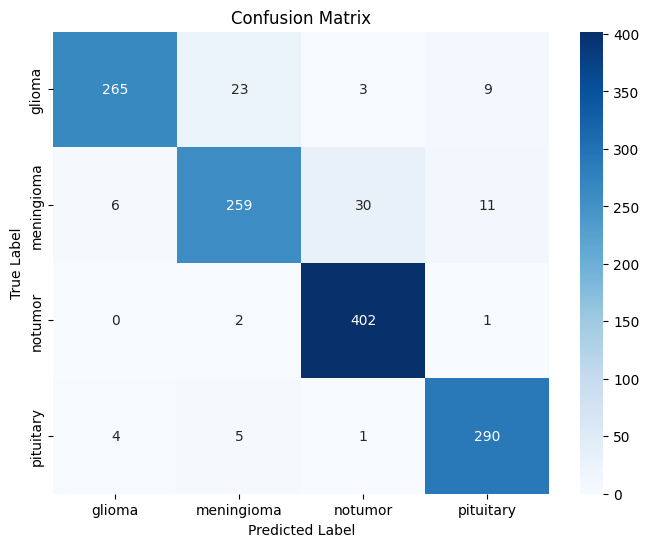

Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.88      0.92       300
  meningioma       0.90      0.85      0.87       306
     notumor       0.92      0.99      0.96       405
   pituitary       0.93      0.97      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



In [12]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with folder names as labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report with folder names as labels
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


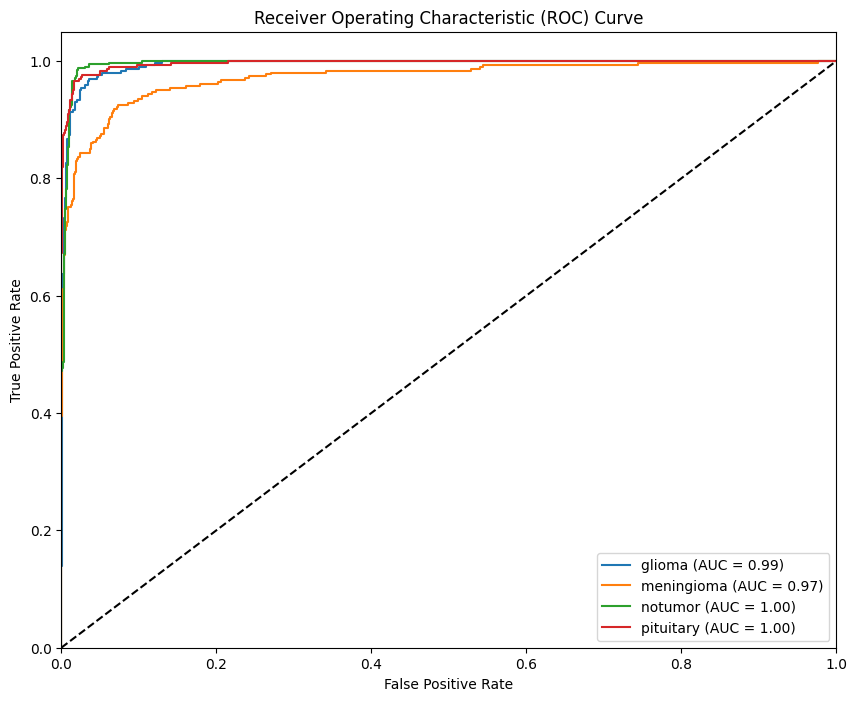

In [13]:
# Compute ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [14]:
model.save('cnn_model.h5')

C:\Users\kalpa\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
